In [1]:
from utils import *

import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pylab as plt
import random

import tensorflow as tf
from keras import backend as K
from keras import initializers

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)
my_init = initializers.glorot_uniform(seed=42)

In [3]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Loading data

In [4]:
X, Y = load_raw_data(data_folder)
X, Y, Y_std, Y_soc, Y_fourier = prepare_x_y(X, Y)
X_train, X_test, Y_train, Y_test, Y_train_std, Y_test_std, \
                     Y_train_soc, Y_test_soc, Y_train_fourier, Y_test_fourier = prepare_train_test(X, 
                                                                                                   Y, 
                                                                                                   Y_std, 
                                                                                                   Y_soc, 
                                                                                                   Y_fourier)

In [5]:
test_feature(Y, Y_std)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.02      0.02      0.02       102
          2       0.00      0.00      0.00        20
          3       0.00      0.00      0.00        31
          4       0.00      0.00      0.00        42
          5       0.45      0.13      0.20       100
          6       0.00      0.00      0.00        20
          7       0.00      0.00      0.00         5
          8       0.00      0.00      0.00         3
          9       0.21      0.69      0.32       101
         10       0.00      0.00      0.00        20
         11       0.00      0.00      0.00        28
         12       0.25      0.73      0.37       100
         13       0.00      0.00      0.00        20
         14       0.00      0.00      0.00       100
         15       0.00      0.00      0.00        20
         16       0.22      0.27      0.24       102
         17       0.00      0.00      0.00   

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
test_feature(Y, Y_soc)

             precision    recall  f1-score   support

          0       0.92      0.92      0.92        12
          1       0.40      0.73      0.52       102
          2       0.00      0.00      0.00        20
          3       0.00      0.00      0.00        31
          4       0.00      0.00      0.00        42
          5       0.21      0.30      0.25       100
          6       0.00      0.00      0.00        20
          7       0.00      0.00      0.00         5
          8       0.00      0.00      0.00         3
          9       0.31      0.42      0.35       101
         10       0.00      0.00      0.00        20
         11       0.00      0.00      0.00        28
         12       0.33      0.19      0.24       100
         13       0.00      0.00      0.00        20
         14       0.22      0.02      0.04       100
         15       0.00      0.00      0.00        20
         16       0.27      0.76      0.40       102
         17       0.00      0.00      0.00   

In [7]:
test_feature(Y, Y_fourier, True)

             precision    recall  f1-score   support

          0       0.92      1.00      0.96        12
          1       0.84      0.84      0.84       102
          2       1.00      1.00      1.00        20
          3       0.74      0.94      0.83        31
          4       1.00      1.00      1.00        42
          5       0.75      0.92      0.83       100
          6       0.60      0.15      0.24        20
          7       1.00      1.00      1.00         5
          8       1.00      1.00      1.00         3
          9       0.52      0.75      0.61       101
         10       0.79      0.55      0.65        20
         11       0.53      0.32      0.40        28
         12       0.76      0.91      0.83       100
         13       0.86      0.30      0.44        20
         14       0.66      0.52      0.58       100
         15       0.50      0.25      0.33        20
         16       0.58      0.49      0.53       102
         17       0.62      0.50      0.56   

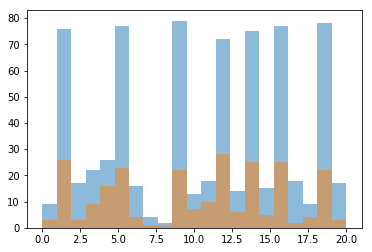

In [8]:
plt.figure()
plt.hist([np.argmax(y) for y in Y_train], label = 'Train set', alpha = 0.5, bins = 21)
plt.hist([np.argmax(y) for y in Y_test], label = 'Test set', alpha = 0.5, bins = 21)
plt.show()

# Defining single task model

In [9]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [10]:
inn = Input(shape = (X_train.shape[1], X_train.shape[2], ))

x = Conv1D(16, 5, activation='relu', kernel_initializer=my_init)(inn)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='relu', kernel_initializer=my_init)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu', kernel_initializer=my_init)(x)
x = GlobalMaxPooling1D()(x)
out = Dense(Y_test.shape[1], activation = 'softmax', kernel_initializer=my_init)(x)

model = Model(inputs=[inn], outputs=[out])

model.compile(loss='categorical_crossentropy',
              metrics = ['accuracy'], optimizer = Adam(clipnorm = 1.))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9318, 3)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9314, 16)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1862, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1858, 32)          2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 371, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 367, 64)           10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
__________

In [12]:
h = model.fit(
    X_train, Y_train,
    epochs = 10,
    batch_size = 64,
    validation_data = (X_test, Y_test),
    verbose = True,
    shuffle = False
)

Train on 734 samples, validate on 245 samples
Epoch 1/10
734/734 [==============================] - 7s 9ms/step - loss: 8.0418 - acc: 0.1308 - val_loss: 6.3954 - val_acc: 0.1551
Epoch 2/10
734/734 [==============================] - 6s 8ms/step - loss: 4.6429 - acc: 0.2125 - val_loss: 3.3135 - val_acc: 0.2041
Epoch 3/10
734/734 [==============================] - 6s 8ms/step - loss: 2.5652 - acc: 0.2684 - val_loss: 2.4551 - val_acc: 0.2816
Epoch 4/10
734/734 [==============================] - 7s 9ms/step - loss: 1.9675 - acc: 0.4046 - val_loss: 1.9489 - val_acc: 0.4490
Epoch 5/10
734/734 [==============================] - 6s 9ms/step - loss: 1.5944 - acc: 0.4959 - val_loss: 1.6776 - val_acc: 0.4735
Epoch 6/10
734/734 [==============================] - 6s 8ms/step - loss: 1.3541 - acc: 0.5722 - val_loss: 1.5143 - val_acc: 0.4571
Epoch 7/10
734/734 [==============================] - 6s 9ms/step - loss: 1.1787 - acc: 0.6063 - val_loss: 1.3906 - val_acc: 0.4531
Epoch 8/10
734/734 [==========

In [13]:
print classification_report([np.argmax(x) for x in Y_test], 
                            [np.argmax(x) for x in model.predict(X_test)])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       0.50      0.31      0.38        26
          2       0.43      1.00      0.60         3
          3       0.64      0.78      0.70         9
          4       0.67      0.25      0.36        16
          5       0.63      0.96      0.76        23
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.56      0.68      0.61        22
         10       0.67      0.57      0.62         7
         11       0.50      0.20      0.29        10
         12       0.71      0.86      0.77        28
         13       0.83      0.83      0.83         6
         14       0.71      0.60      0.65        25
         15       0.71      1.00      0.83         5
         16       1.00      0.16      0.28        25
         17       0.67      1.00      0.80   

# Multitask model + std as auxiliary loss

In [14]:
inn = Input(shape = (X_train.shape[1], X_train.shape[2], ))

x = Conv1D(16, 5, activation='relu', kernel_initializer=my_init)(inn)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='relu', kernel_initializer=my_init)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu', kernel_initializer=my_init)(x)
x = GlobalMaxPooling1D()(x)
out = Dense(Y_test.shape[1], activation = 'softmax', name = 'classification', kernel_initializer=my_init)(x)
out2 = Dense(1, activation = 'linear', name = 'regression', kernel_initializer=my_init)(x)

model = Model(inputs=[inn], outputs=[out, out2])

model.compile(loss=['categorical_crossentropy', 'mse'],
              metrics = {'classification': 'accuracy'}, optimizer = Adam(clipnorm = 1.), loss_weights = [1, 1e-3])

In [15]:
h = model.fit(
    X_train, [Y_train, Y_train_std],
    epochs = 10,
    batch_size = 64,
    validation_data = (X_test, [Y_test, Y_test_std]),
    verbose = True,
    shuffle = False
)

Train on 734 samples, validate on 245 samples
Epoch 1/10
734/734 [==============================] - 7s 9ms/step - loss: 7.9814 - classification_loss: 7.8782 - regression_loss: 103.1249 - classification_acc: 0.1349 - val_loss: 6.4014 - val_classification_loss: 6.3912 - val_regression_loss: 10.1692 - val_classification_acc: 0.1510
Epoch 2/10
734/734 [==============================] - 6s 8ms/step - loss: 4.7038 - classification_loss: 4.6947 - regression_loss: 9.0751 - classification_acc: 0.2302 - val_loss: 3.5891 - val_classification_loss: 3.5805 - val_regression_loss: 8.5808 - val_classification_acc: 0.2449
Epoch 3/10
734/734 [==============================] - 6s 8ms/step - loss: 2.6548 - classification_loss: 2.6413 - regression_loss: 13.4394 - classification_acc: 0.2793 - val_loss: 2.4982 - val_classification_loss: 2.4777 - val_regression_loss: 20.4502 - val_classification_acc: 0.2816
Epoch 4/10
734/734 [==============================] - 6s 8ms/step - loss: 1.9948 - classification_loss:

In [16]:
print classification_report([np.argmax(x) for x in Y_test], 
                            [np.argmax(x) for x in model.predict(X_test)[0]])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       0.35      0.62      0.44        26
          2       0.50      1.00      0.67         3
          3       0.75      0.67      0.71         9
          4       0.75      0.19      0.30        16
          5       0.62      1.00      0.77        23
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.68      0.68      0.68        22
         10       0.70      1.00      0.82         7
         11       0.67      0.40      0.50        10
         12       0.81      0.89      0.85        28
         13       1.00      0.83      0.91         6
         14       0.76      0.64      0.70        25
         15       0.71      1.00      0.83         5
         16       0.64      0.28      0.39        25
         17       0.67      1.00      0.80   

# Multitask model + sum of change as auxiliary loss

In [17]:
inn = Input(shape = (X_train.shape[1], X_train.shape[2], ))

x = Conv1D(16, 5, activation='relu', kernel_initializer=my_init)(inn)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='relu', kernel_initializer=my_init)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu', kernel_initializer=my_init)(x)
x = GlobalMaxPooling1D()(x)
out = Dense(Y_test.shape[1], activation = 'softmax', name = 'classification', kernel_initializer=my_init)(x)
out2 = Dense(1, activation = 'linear', name = 'regression', kernel_initializer=my_init)(x)

model = Model(inputs=[inn], outputs=[out, out2])

model.compile(loss=['categorical_crossentropy', 'mse'],
              metrics = {'classification': 'accuracy'}, optimizer = Adam(clipnorm = 1.), loss_weights = [1, 1e-6])

In [18]:
h = model.fit(
    X_train, [Y_train, Y_train_soc],
    epochs = 10,
    batch_size = 64,
    validation_data = (X_test, [Y_test, Y_test_soc]),
    verbose = True,
    shuffle = False
)

Train on 734 samples, validate on 245 samples
Epoch 1/10
734/734 [==============================] - 7s 9ms/step - loss: 11.1478 - classification_loss: 8.0318 - regression_loss: 3115966.6839 - classification_acc: 0.1308 - val_loss: 8.9401 - val_classification_loss: 6.3911 - val_regression_loss: 2548998.4939 - val_classification_acc: 0.1673
Epoch 2/10
734/734 [==============================] - 6s 9ms/step - loss: 7.7702 - classification_loss: 4.6649 - regression_loss: 3105226.9428 - classification_acc: 0.2153 - val_loss: 5.8648 - val_classification_loss: 3.3222 - val_regression_loss: 2542660.2918 - val_classification_acc: 0.2082
Epoch 3/10
734/734 [==============================] - 7s 9ms/step - loss: 5.6565 - classification_loss: 2.5536 - regression_loss: 3102907.6458 - classification_acc: 0.2738 - val_loss: 5.0089 - val_classification_loss: 2.4654 - val_regression_loss: 2543461.0959 - val_classification_acc: 0.2776
Epoch 4/10
734/734 [==============================] - 6s 8ms/step - los

In [19]:
print classification_report([np.argmax(x) for x in Y_test], 
                            [np.argmax(x) for x in model.predict(X_test)[0]])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       0.42      0.38      0.40        26
          2       0.43      1.00      0.60         3
          3       0.67      0.67      0.67         9
          4       0.73      0.69      0.71        16
          5       0.63      0.96      0.76        23
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.67      0.73      0.70        22
         10       0.75      0.43      0.55         7
         11       0.33      0.10      0.15        10
         12       0.75      0.86      0.80        28
         13       0.80      0.67      0.73         6
         14       0.67      0.64      0.65        25
         15       0.71      1.00      0.83         5
         16       0.68      0.52      0.59        25
         17       0.00      0.00      0.00   

# Multitask model + Fourier coefs as auxiliary loss

In [20]:
inn = Input(shape = (X_train.shape[1], X_train.shape[2], ))

x = Conv1D(16, 5, activation='relu', kernel_initializer=my_init)(inn)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='relu', kernel_initializer=my_init)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu', kernel_initializer=my_init)(x)
x = GlobalMaxPooling1D()(x)
out = Dense(Y_test.shape[1], activation = 'softmax', name = 'classification', kernel_initializer=my_init)(x)
out2 = Dense(Y_train_fourier.shape[1], activation = 'linear', name = 'regression', kernel_initializer=my_init)(x)

model = Model(inputs=[inn], outputs=[out, out2])

model.compile(loss=['categorical_crossentropy', 'mse'],
              metrics = {'classification': 'accuracy'}, optimizer = Adam(clipnorm = 1.), loss_weights = [1, 1e-2])

In [21]:
h = model.fit(
    X_train, [Y_train, Y_train_fourier],
    epochs = 10,
    batch_size = 64,
    validation_data = (X_test, [Y_test, Y_test_fourier]),
    verbose = True,
    shuffle = False
)

Train on 734 samples, validate on 245 samples
Epoch 1/10
734/734 [==============================] - 7s 9ms/step - loss: 8.1410 - classification_loss: 7.8511 - regression_loss: 28.9874 - classification_acc: 0.1281 - val_loss: 6.1778 - val_classification_loss: 6.0995 - val_regression_loss: 7.8250 - val_classification_acc: 0.1633
Epoch 2/10
734/734 [==============================] - 6s 8ms/step - loss: 4.0594 - classification_loss: 4.0178 - regression_loss: 4.1614 - classification_acc: 0.1757 - val_loss: 2.9085 - val_classification_loss: 2.8890 - val_regression_loss: 1.9509 - val_classification_acc: 0.2286
Epoch 3/10
734/734 [==============================] - 6s 8ms/step - loss: 2.3775 - classification_loss: 2.3581 - regression_loss: 1.9350 - classification_acc: 0.3106 - val_loss: 2.3183 - val_classification_loss: 2.2984 - val_regression_loss: 1.9896 - val_classification_acc: 0.2939
Epoch 4/10
734/734 [==============================] - 6s 8ms/step - loss: 1.8467 - classification_loss: 1.8

In [22]:
print classification_report([np.argmax(x) for x in Y_test], 
                            [np.argmax(x) for x in model.predict(X_test)[0]])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       0.62      0.31      0.41        26
          2       0.50      1.00      0.67         3
          3       0.70      0.78      0.74         9
          4       0.82      0.56      0.67        16
          5       0.67      0.96      0.79        23
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         1
          9       0.86      0.55      0.67        22
         10       0.83      0.71      0.77         7
         11       0.00      0.00      0.00        10
         12       0.76      0.93      0.84        28
         13       0.80      0.67      0.73         6
         14       0.62      0.52      0.57        25
         15       0.62      1.00      0.77         5
         16       0.60      0.72      0.65        25
         17       0.00      0.00      0.00   

In [ ]:
# homework: to get 65% F1